# Entrega Final do Projeto [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SimpleANPR/anpr/blob/main/Entrega_Final.ipynb)

Esse Jupyter Notebook contém os resultados finais do projeto, apresentando um comparativo das abordagens selecionadas. 

In [1]:
# OBS:. o processo de otimização demanda
#   um tempo considerável (~1h)
RUN_OPTIMIZATION_EDGE: bool = False
RUN_OPTIMIZATION_WAVELET: bool = False
RUN_OPTIMIZATION_ESTIMATOR: bool = False
RUN_OPTIMIZATION_EASY_OCR: bool = False

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
    # Configurando o ambiente para execução no colab
    !git clone https://github.com/SimpleANPR/anpr
    %cd /content/anpr
    %pip install -r requirements.txt

In [3]:
import numpy as np

rng = np.random.default_rng(42)
rng_edge = np.random.default_rng(rng.integers(0, 99999))
rng_texture_color = np.random.default_rng(rng.integers(0, 99999))
rng_estimator = np.random.default_rng(rng.integers(0, 99999))

## Dataset

O dataset selecionado foi o conjunto de imagens de benchmark utilizados pelo OpenALPR (https://github.com/openalpr/benchmarks) para diferentes países (BR, USA, EU) e cidades. Ao todo, temos um total de 444 imagens anotados de veículos e suas placas.

In [4]:
from anpr.datasets.open_alpr import OpenALPRDataset
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import plotly.express as px

In [5]:
# Acessando o dataset (realiza o download automático das imagens)
ds = OpenALPRDataset()
print(f'Quantidade total de imagens: {ds.total_images()}')

Quantidade total de imagens: 444


In [6]:
def show_image_with_plate(img):
    """Método utilitário que mostra uma
    imagem anotada do dataset OpenALPR.

    Args:
        img (OpenALPRImage): imagem anotada.
    """
    print(f'Placa: {img.plate_text}')
    _, ax = plt.subplots()
    ax.imshow(img.image)
    x, y, w, h = img.plate_rect
    ax.add_patch(patches.Rectangle((x, y), w, h, 
                                linewidth=1, 
                                edgecolor='r', 
                                facecolor='none'))

Placa: PUT6858


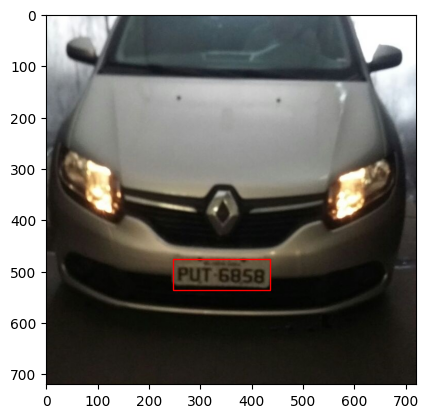

In [7]:
# Exemplo de uma imagem anotada do dataset
img = ds.image_at(120)
show_image_with_plate(img)

### Variedade nos formatos de Placas

Visto que foram coletadas imagens de diversos países, temos uma diferença considerável no formato das placas e letras que as compõem.

Placa do Brasil (BR)
Placa: JSG9648


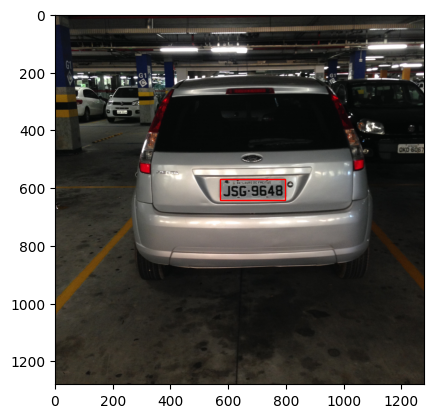

In [8]:
print('Placa do Brasil (BR)')
img = ds.image('JSG9648.jpg')
show_image_with_plate(img)

Placa dos Estados Unidos (US)
Placa: 980YTB


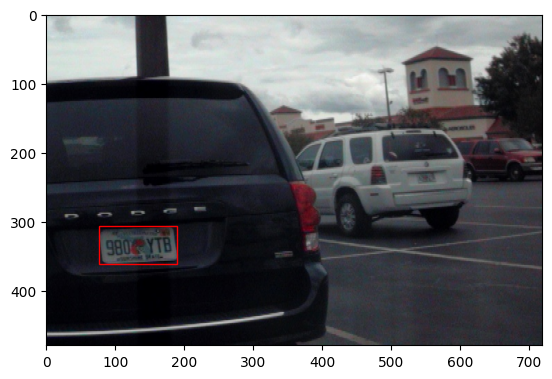

In [9]:
print('Placa dos Estados Unidos (US)')
img = ds.image('car14.jpg')
show_image_with_plate(img)

Placa dos Estados Unidos (US)
Placa: 10DTM


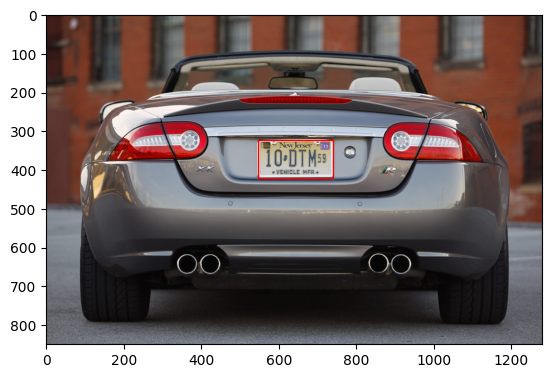

In [10]:
print('Placa dos Estados Unidos (US)')
img = ds.image('car7.jpg')
show_image_with_plate(img)

Placa da Europa (EU)
Placa: FWE50


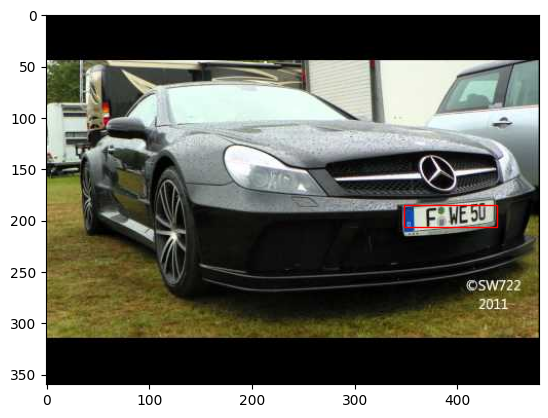

In [11]:
print('Placa da Europa (EU)')
img = ds.image('eu3.jpg')
show_image_with_plate(img)

Placa da Europa (EU)
Placa: VW4X4WP


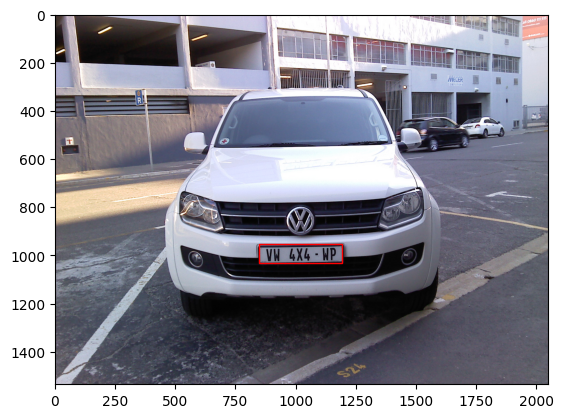

In [12]:
print('Placa da Europa (EU)')
img = ds.image('eu7.jpg')
show_image_with_plate(img)

# SimpleANPR: Uma abordagem simplificada para Reconhecimento de Placas Veiculares

Essa seção contém um comparativo de 3 abordagens para ANPR utilizando o framework proposto. Especificamente, testamos 3 formas de detecção de placas diferentes: (i) baseada em Bordas; (ii) baseada em Cor/Textura; (iii) baseada em Classificadores.


In [13]:
# ==== Imports ====
import json

import cv2
import numpy as np
import pandas as pd
import shapely
import textdistance

from anpr.binarization.adaptative_gaussian import AdaptativeGaussianBinarizer
from anpr.binarization.adaptative_mean import AdaptativeMeanBinarizer
from anpr.binarization.kittler import KittlerBinarizer
from anpr.binarization.otsu import OtsuBinarizer
from anpr.core.binarizer import Binarizer
from anpr.core.image_processor import ImageProcessor
from anpr.core.plate_detector import DetectionResult, PlateDetector
from anpr.datasets.open_alpr import OpenALPRDataset, OpenALPRImage
from anpr.detection.estimator_detector import EstimatorDetector
from anpr.detection.wavelet_detector import WaveletDetector
from anpr.generic.brightness import Brightness
from anpr.generic.contrast import Contrast
from anpr.generic.filter_bilateral import FilterBilateral
from anpr.generic.filter_gaussian import FilterGaussian
from anpr.generic.filter_mean import FilterMean
from anpr.generic.filter_median import FilterMedian
from anpr.generic.filter_nlm import FilterNLM
from anpr.generic.grayscale import GrayScale
from anpr.generic.histogram_normalization import HistogramNormalization
from anpr.generic.morphological_closing import MorphologicalClosing
from anpr.generic.morphological_opening import MorphologicalOpening
from anpr.generic.negative import Negative
from anpr.ocr.easy_ocr import EasyOCR

In [14]:
# ==== Definição de classes utilitárias ====
class Identity(ImageProcessor):
    def process(self, image: np.ndarray) -> np.ndarray:
        return image


class AggregateProcessor(ImageProcessor):
    """Agregador de etapas de processamento
    sequencial. Aplica cada um dos processamentos
    de forma sequencial (i.e., saída de um é entrada
    para o próximo).
    """

    def __init__(self, processors: list[ImageProcessor]) -> None:
        self._processors = processors

    def process(self, image: np.ndarray) -> np.ndarray:
        for p in self._processors:
            image = p.process(image)

        return image


class DetectorWithProcessing(PlateDetector):
    def __init__(self,
                 detector: PlateDetector,
                 processor: ImageProcessor,
                 apply_processor_in_detect: bool = False):
        self._detector = detector
        self._processor = processor
        self._apply = apply_processor_in_detect

    @property
    def detector(self) -> PlateDetector:
        return self._detector

    @property
    def processor(self) -> ImageProcessor:
        return self._processor

    def detect(self, image: np.ndarray) -> DetectionResult:
        if self._apply:
            image = self.processor.process(image)

        return self._detector.detect(image)

In [15]:
# ==== Definição de variáveis utilitárias ====
# Threshold para considerar o overlap de retângulos
#   como correto. O valor foi selecionado empiricamente
#   já que uma intersecção que compreende 60% da área,
#   é boa o suficiente para considerar que foi
#   encontrada a placa.
correct_overlap_th: float = 0.6

# Threshold para considerar a saída do OCR como
#   correta. O valor foi selecionado com base
#   na média de similaridade que podemos esperar
#   usando as anotações do dataset.
plate_text_similarity_th: float = 0.6

# Pré-processamento para o OCR, inicializamos como identidade.
preprocessing_ocr = Identity()

# EasyOCR, iniciamos com a linguagem padrão.
ocr = EasyOCR()

In [16]:
# ==== Definição de funções utilitárias ====
def calculate_metrics(detector: PlateDetector,
                      ds: OpenALPRDataset,
                      indices: list[int] | None = None) -> dict:
    global ocr
    global preprocessing_ocr
    
    if indices is None:
        indices = list(range(ds.total_images()))

    metrics = {
        'Imagens Segmentadas': 0,
        'Imagens não Segmentadas': 0,
        'Acertos Detecção': 0,
        'Erros Detecção': 0,
        'Acertos OCR': 0,
        'Erros OCR': 0,
    }

    def _correct_plate(true, pred):
        true_rect = shapely.box(xmin=true[0], xmax=true[0] + true[2],
                                ymin=true[1], ymax=true[1] + true[3])
        pred_rect = shapely.box(xmin=pred[0], xmax=pred[0] + pred[2],
                                ymin=pred[1], ymax=pred[1] + pred[3])

        if not pred_rect.intersects(true_rect):
            return False

        int_area = shapely.intersection(true_rect, pred_rect).area
        return int_area >= correct_overlap_th * true_rect.area

    for i in indices:
        ds_img = ds.image_at(i)
        detection = detector.detect(ds_img.image)

        if detection.found_plate:
            metrics['Imagens Segmentadas'] += 1
            if _correct_plate(ds_img.plate_rect,
                              detection.plate_polygon):
                metrics['Acertos Detecção'] += 1

                # Preparando o teste do OCR
                plate_img = detection.plate_image.copy()
                plate_img = preprocessing_ocr.process(plate_img)

                # Obtendo saída do OCR
                plate_text = ds_img.plate_text
                ocr_text = ocr.extract_text(plate_img)

                # Calculando a similaridade Jaccard
                sim = textdistance.jaccard.similarity(plate_text,
                                                      ocr_text)

                if sim >= plate_text_similarity_th:
                    metrics['Acertos OCR'] += 1
                else:
                    metrics['Erros OCR'] += 1
            else:
                metrics['Erros Detecção'] += 1
        else:
            metrics['Imagens não Segmentadas'] += 1

    return metrics


def show_detection(detector: DetectorWithProcessing,
                   ds: OpenALPRDataset,
                   image_idx: int,
                   color_true: str = 'g',
                   color_candidate: str = 'b',
                   color_selected: str = 'r',
                   cmap_processed=None):
    global ocr
    global preprocessing_ocr
    
    ds_img = ds.image_at(image_idx)
    detection = detector.detect(ds_img.image)
    processed_img = detector.processor.process(ds_img.image)

    fig, axs = plt.subplots(1, 2,
                            figsize=(12, 12),
                            facecolor='w',
                            edgecolor='k')
    axs = axs.ravel()

    def _add_patch(ax, x, y, w, h, color):
        axs[i].add_patch(patches.Rectangle((x, y), w, h,
                                           linewidth=1,
                                           edgecolor=color,
                                           facecolor='none'))

    for i, img in enumerate([ds_img.image,
                             processed_img]):
        cmap = None
        if i > 0:
            cmap = cmap_processed

        # Colocando a imagem
        axs[i].imshow(img, cmap=cmap)

        # Adicionando marcação real da placa
        _add_patch(axs[i],
                   *ds_img.plate_rect,
                   color_true)
        if i == 0:
            print(f'Placa: {ds_img.plate_text}')

        # Adicionando marcações da plata
        if detection.found_plate:
            _add_patch(axs[i],
                       *detection.plate_polygon,
                       color_selected)
            if i == 0:
                try:
                    p_img = preprocessing_ocr.process(detection.plate_image)
                    print(f'Placa extraída: {ocr.extract_text(p_img)}')
                except Exception:
                    print('Nenhuma placa encontrada.')

        # Adicionando candidatos (se disponíveis)
        extras = detection.extras
        if extras is not None:
            if hasattr(extras, 'candidates'):
                for c in getattr(extras, 'candidates'):
                    if c == detection.plate_polygon:
                        continue

                    _add_patch(axs[i],
                               *c,
                               color_candidate)


def accuracy_from_metrics(metrics: dict) -> float:
    total = metrics['Imagens Segmentadas'] + metrics['Imagens não Segmentadas']
    return metrics['Acertos Detecção'] / total

## Ground-Truth: Melhores resultados com o EasyOCR

Antes de comparar os resultados com os detectores de placa, vamos calcular quais melhores possíveis resultados que podemos esperar considerando as anotações presentes no dataset (ground-truth) com o EasyOCR. 


In [17]:
import optuna
from optuna.samplers import TPESampler

# === Buscando a melhor configuração de pré-processamento + modelo ===
# Visto que o principal desenvolvimento no projeto voltou-se a detecção
#   da placa, vamos utilizar a melhor configuração do EasyOCR no conjunto
#   de dados completo.

if RUN_OPTIMIZATION_EASY_OCR:
    _LOW_PASS = {
        'gaussian': FilterGaussian,
        'mean': FilterMean,
        'median': FilterMedian
    }


    def objective(trial):
        # Obtendo configurações de pré-processamento
        language = trial.suggest_categorical("language", ['pt', 'en', 'es', 'it', 'fr'])

        steps = {
            'low_pass': trial.suggest_categorical("low_pass", ['identity', 'gaussian',
                                                            'mean', 'median']),
            'morphological': trial.suggest_categorical("morphological", ['identity', 'opening', 'closing']),
            'luminosity': trial.suggest_categorical("luminosity", ['identity', 'histogram_normalization',
                                                                'contrast', 'brightness']),
            'binarizer': trial.suggest_categorical("binarizer", ['identity', 'otsu', 'kittler'])

        }

        params = {
            'low_pass_kernel': trial.suggest_categorical("low_pass_kernel", [3, 5, 7, 11, 17,
                                                                            21, 25, 31]),
            'morph_shape': trial.suggest_categorical("morph_shape", [cv2.MORPH_CROSS, cv2.MORPH_ELLIPSE,
                                                                    cv2.MORPH_RECT]),
            'morph_size': trial.suggest_categorical("morph_size", [3, 5, 7, 11]),
            'brightness_offset': trial.suggest_int("brightness_offset", -50, 50, step=10),
            'contrast_multiplier': trial.suggest_float("contrast_multiplier", 0.25, 2.0, step=0.25)
        }

        # Criando o conjunto de pré-processamento
        processing = [GrayScale()]

        for s, v in steps.items():
            processor = None

            if v == 'identity':
                continue

            if s == 'low_pass':
                kernel_size = params['low_pass_kernel']
                processor = _LOW_PASS[v](kernel_size)
            elif s == 'morphological':
                shape = params['morph_shape']
                size = params['morph_size']
                element = cv2.getStructuringElement(shape, (size, size))
                processor = MorphologicalClosing if v == 'closing' else MorphologicalOpening
                processor = processor(element)
            elif s == 'luminosity':
                if 'histogram' in v:
                    processor = HistogramNormalization()
                elif v == 'contrast':
                    processor = Contrast(params['contrast_multiplier'])
                elif v == 'brightness':
                    processor = Brightness(params['brightness_offset'])
            elif s == 'binarizer':
                processor = OtsuBinarizer() if v == 'otsu' else KittlerBinarizer()

            processing.append(processor)


        # Convertendo a lista de processamento para um ImageProcessor
        processing = AggregateProcessor(processing)
        ocr = EasyOCR(language)

        # Calculando similaridade média no dataset
        similarities = []
        for i in range(ds.total_images()):
            # Obtendo amostra do dataset
            ds_img = ds.image_at(i)

            # Obtendo posição da placa
            x, y, w, h = ds_img.plate_rect

            # Obtendo a placa e realizando pré-processamento
            plate = ds_img.image[y:y+h, x:x+w]
            plate = processing.process(plate)

            # Extraindo texto
            extracted = ocr.extract_text(plate)

            # Calculando similaridade
            sim = textdistance.jaccard.similarity(ds_img.plate_text,
                                                extracted)
            similarities.append(sim)

        # Armazenando o pré-processador
        trial.set_user_attr('processor', processing)
        trial.set_user_attr('language', language)

        # Usando similaridade média como objetivo
        return np.mean(similarities)


    # Iniciando experimento
    sampler = TPESampler(seed=rng.integers(0, 9999))
    study = optuna.create_study(study_name='ocr_preprocess',
                                direction="maximize",
                                sampler=sampler)
    study.optimize(objective,
                n_trials=100,
                n_jobs=1,
                show_progress_bar=True)

    # Atualizando com as melhores configurações para o OCR
    preprocessing_ocr = study.best_trial.user_attrs['processor']
    ocr = EasyOCR(study.best_trial.user_attrs['language'])
else:
    print('Pulando otimização das configurações para o EasyOCR. '
          'Utilizando valores hard-coded da última otimização.')
    preprocessing_ocr = AggregateProcessor([GrayScale(),
                                            Brightness(50)])
    ocr = EasyOCR('pt')

Pulando otimização das configurações para o EasyOCR. Utilizando valores hard-coded da última otimização.


/home/moesiof/Work/UFRPE/anpr/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def ground_truth_recognition(ds: OpenALPRDataset,
                             indices: list[int] | None = None):
    global ocr
    global preprocessing_ocr
    
    if indices is None:
        indices = list(range(ds.total_images()))

    metrics = {
        'Acertos OCR': 0,
        'Erros OCR': 0,
    }

    for i in indices:
        ds_img = ds.image_at(i)
        x, y, w, h = ds_img.plate_rect
        plate_img = ds_img.image[y:y+h, x:x+w].copy()
        plate_img = preprocessing_ocr.process(plate_img)

        # Obtendo saída do OCR
        plate_text = ds_img.plate_text
        ocr_text = ocr.extract_text(plate_img)

        # Calculando a similaridade Jaccard
        sim = textdistance.jaccard.similarity(plate_text,
                                                ocr_text)

        if sim >= plate_text_similarity_th:
            metrics['Acertos OCR'] += 1
        else:
            metrics['Erros OCR'] += 1

    return metrics

print(json.dumps(ground_truth_recognition(ds),
                 indent=2,
                 ensure_ascii=False))

{
  "Acertos OCR": 260,
  "Erros OCR": 184
}


## Abordagem 1: Detecção baseada em Bordas

### Exemplo "Bom"

### Exemplo "Médio"

### Exemplo "Ruim"

## Abordagem 2: Detecção baseada em Textura (Wavelet)

In [19]:
baseline_wavelet_detector = DetectorWithProcessing(WaveletDetector(),
                                                   Identity(),
                                                   apply_processor_in_detect=False)
metrics_baseline_wavelet_detector = calculate_metrics(baseline_wavelet_detector,
                                                      ds)
print(json.dumps(metrics_baseline_wavelet_detector,
                 indent=2,
                 ensure_ascii=False))

{
  "Imagens Segmentadas": 364,
  "Imagens não Segmentadas": 80,
  "Acertos Detecção": 115,
  "Erros Detecção": 249,
  "Acertos OCR": 50,
  "Erros OCR": 65
}


### Exemplo "Bom"

Placa: RK819AM
Placa extraída: FRK289AN


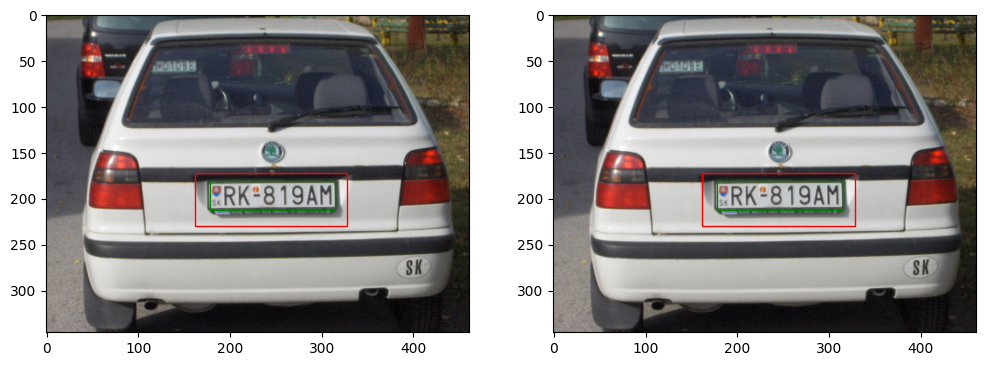

In [20]:
show_detection(baseline_wavelet_detector, ds, 200, cmap_processed='gray')

### Exemplo "Médio"

Placa: JRV1942
Placa extraída: S


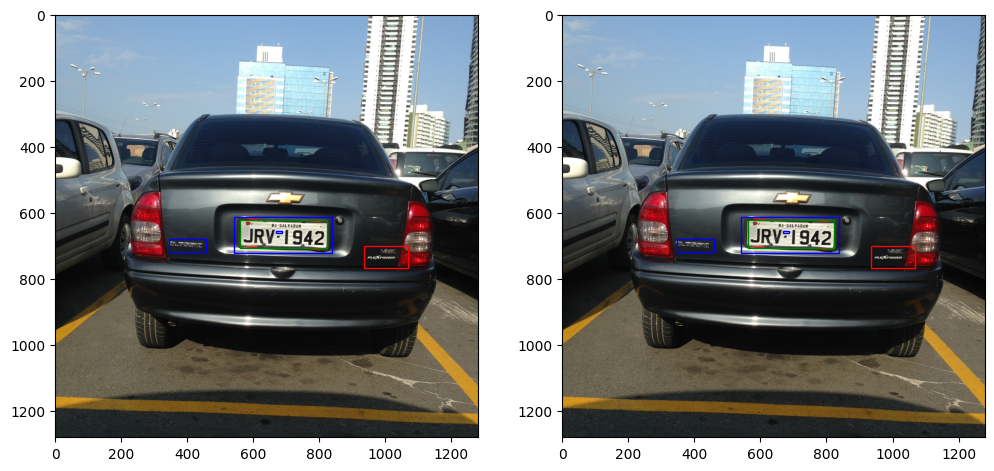

In [21]:
show_detection(baseline_wavelet_detector, ds, 26, cmap_processed='gray')

### Exemplo "Ruim"

Placa: DH5X9P
Placa extraída: 322


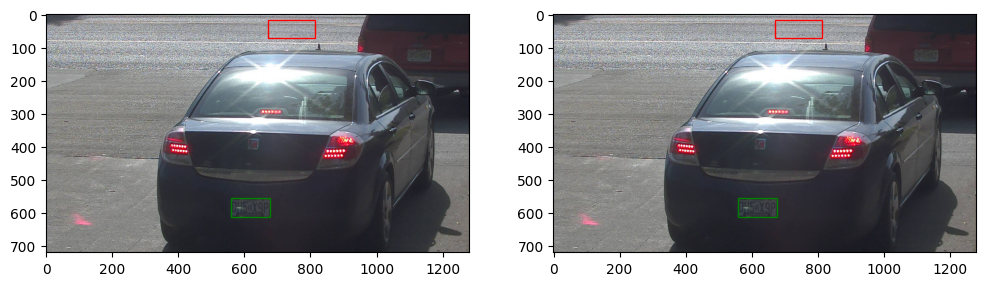

In [22]:
show_detection(baseline_wavelet_detector, ds, 280, cmap_processed='gray')

## Abordagem 3: Detecção baseada em Classificadores

In [23]:
# Processamento baseline
baseline_estimator_processing = AggregateProcessor([FilterNLM(21),
                                                    FilterBilateral(11, 5, 5),
                                                    GrayScale(),
                                                    Brightness(-30),
                                                    HistogramNormalization(),
                                                    Contrast(0.5),
                                                    OtsuBinarizer(),
                                                    AdaptativeMeanBinarizer(11, 5),
                                                    Negative()])

# Detector baseline
baseline_estimator_detector = EstimatorDetector(seed=rng_estimator.integers(0, 9999),
                                                estimator_algorithm='gaussian_process',
                                                features=['color', 'texture', 'shape'],
                                                scaler='Standard',
                                                preprocessing=baseline_estimator_processing,
                                                pp_in_predict=True,
                                                max_ch_prop=0.75,
                                                max_rect_ratio=0.4,
                                                min_rect_ratio=0.005,
                                                rect_overlap_th=0.6,
                                                max_neighbor_th=0.05,
                                                ch_dilate_size=25,
                                                ch_dilate_iterations=3,
                                                plate_rect_min_ratio=0.7)

# Treinamento com alguns exemplos de placas
n_samples = 40
rand_indices = rng_estimator.integers(0,
                                      ds.total_images(),
                                      size=n_samples).tolist()
baseline_estimator_detector.fit(rand_indices, ds)

# Calculando métricas
baseline_estimator_detector = DetectorWithProcessing(baseline_estimator_detector,
                                                     baseline_estimator_processing,
                                                     apply_processor_in_detect=False)

metrics_baseline_estimator_detector = calculate_metrics(baseline_estimator_detector, ds)
print(json.dumps(metrics_baseline_estimator_detector, indent=2, ensure_ascii=False))

{
  "Imagens Segmentadas": 376,
  "Imagens não Segmentadas": 68,
  "Acertos Detecção": 215,
  "Erros Detecção": 161,
  "Acertos OCR": 36,
  "Erros OCR": 179
}


### Exemplo "Bom"

Placa: PJF4224
Placa extraída: BJFE4224


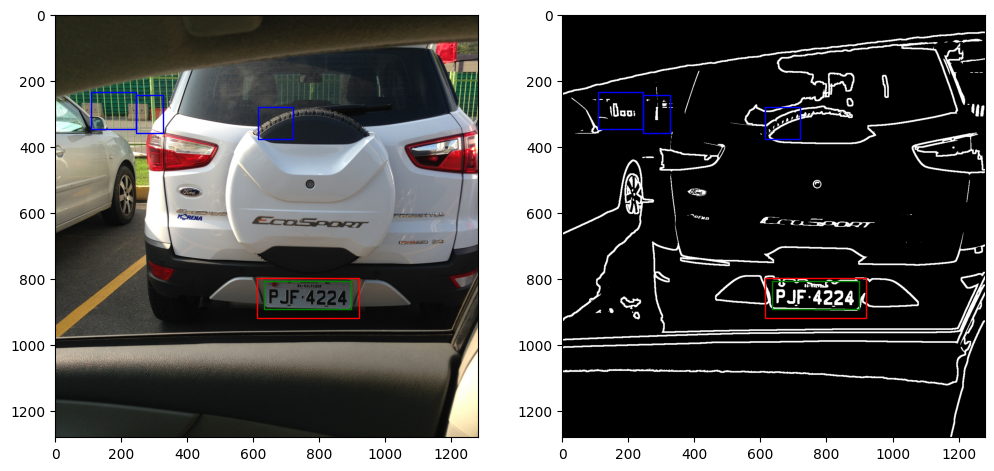

In [24]:
show_detection(baseline_estimator_detector, ds, 100, cmap_processed='gray')

### Exemplo "Médio"

Placa: 5UVR090
Placa extraída: WR09J


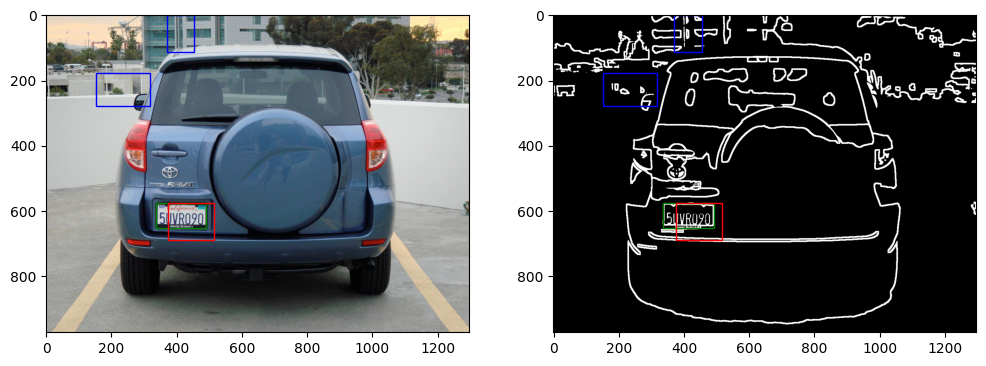

In [25]:
show_detection(baseline_estimator_detector, ds, 130, cmap_processed='gray')

### Exemplo "Ruim"

Placa: DK8F5L
Placa extraída: 5


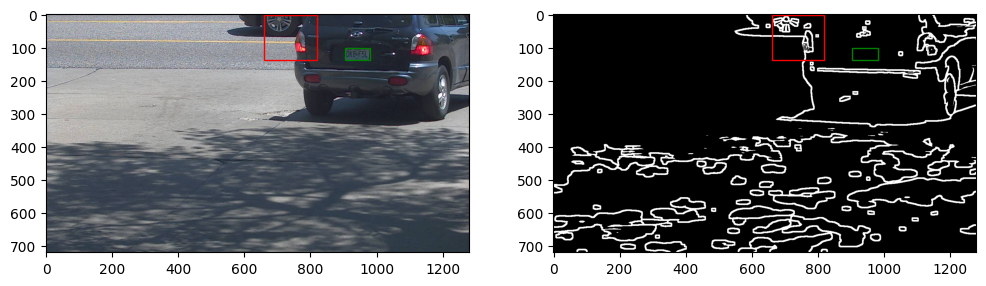

In [26]:
show_detection(baseline_estimator_detector, ds, 430, cmap_processed='gray')

## Otimização de Parâmetros: realizando a tunagem dos detectores

Para validar se existem combinações que produzem melhores resultados do que os baselines apresentados, vamos utilizar algoritmos de otimização de hiperparâmetros com o intuito de gerar automaticamente combinações de pré-processamento, parâmetros e afins.

In [27]:
# ==== Abordagem 1 ====
if RUN_OPTIMIZATION_EDGE:
    # Adicionar código usando optuna aqui
    pass
else:
    pass

In [28]:
# ==== Abordagem 2 ====
if RUN_OPTIMIZATION_WAVELET:
    # Adicionar código usando optuna aqui
    pass
else:
    pass


In [29]:
# ==== Abordagem 3 ====
# Para essa abordagem, temos muitas possibilidade de
#   parâmetros para otimização.
tuned_estimator_detector = None
metrics_tuned_estimator_detector = None

if RUN_OPTIMIZATION_ESTIMATOR:
    n_evaluation = 75
    evaluation_indices = rng_estimator.integers(0,
                                                ds.total_images(),
                                                size=n_evaluation).tolist()

    def objective(trial):
        # Obtendo parâmetros do pré-processamento
        preprocessing_params = {
            'nlm_h': trial.suggest_int("nlm_h", 10, 40, step=5),
            'bilateral_k': trial.suggest_int("bilateral_k", 10, 22, step=2),
            'bilateral_sigma': trial.suggest_int("bilateral_sigma", 5, 85, step=10),
            'brightness_offset': trial.suggest_int("brightness_offset", -50, 50, step=10),
            'contrast_multiplier': trial.suggest_float("contrast_multiplier", 0.25, 2.0, step=0.25),
            'first_binarizer': trial.suggest_categorical('first_binarizer', ['otsu', 'kittler']),
            'adaptative_size': trial.suggest_categorical("adaptative_size", [3, 5, 11, 17, 23, 25, 31]),
            'adaptative_C': trial.suggest_int("adaptative_C", 5, 17, step=2),
        }

        # Criando o conjunto de pré-processamento
        processing = AggregateProcessor([
            FilterNLM(preprocessing_params['nlm_h']),
            FilterBilateral(preprocessing_params['bilateral_k'],
                            preprocessing_params['bilateral_sigma'],
                            preprocessing_params['bilateral_sigma']),
            GrayScale(),
            Brightness(preprocessing_params['brightness_offset']),
            HistogramNormalization(),
            Contrast(preprocessing_params['contrast_multiplier']),
            OtsuBinarizer() if preprocessing_params['first_binarizer'] == 'otsu' else KittlerBinarizer(),
            AdaptativeMeanBinarizer(preprocessing_params['adaptative_size'],
                                    preprocessing_params['adaptative_C']),
            Negative()])

        # Obtendo parâmetros do detector
        params = {
            'estimator_algorithm': trial.suggest_categorical('estimator_algorithm', ['logistic_regression',
                                                                                     'gaussian_process',
                                                                                     'decision_tree',
                                                                                     'extra_trees',
                                                                                     'random_forest']),
            'scaler': trial.suggest_categorical('scaler', ['MinMax', 'Standard']),
            'features': trial.suggest_categorical('features', ['color+shape+texture',
                                                               'color+shape',
                                                               'color+texture',
                                                               'shape+texture']).split('+'),
            'max_ch_prop': trial.suggest_float("max_ch_prop", 0.5, 1.2, step=0.1),
            'max_rect_ratio': trial.suggest_float("max_rect_ratio", 0.3, 0.8, step=0.1),
            'min_rect_ratio': trial.suggest_float("min_rect_ratio", 0.002, 0.01, step=0.001),
            'rect_overlap_th': trial.suggest_float("rect_overlap_th", 0.5, 0.8, step=0.1),
            'max_neighbor_th': trial.suggest_float("max_neighbor_th", 0.02, 0.1, step=0.01),
            'ch_dilate_size': trial.suggest_int("ch_dilate_size", 11, 35),
            'ch_dilate_iterations': trial.suggest_int("ch_dilate_iterations", 1, 4),
            'plate_rect_min_ratio': trial.suggest_float("plate_rect_min_ratio", 0.5, 0.9, step=0.05)
        }

        # Criando detector
        detector_seed = rng_estimator.integers(0, 9999)
        detector = EstimatorDetector(seed=detector_seed,
                                     preprocessing=processing,
                                     **params)

        # Treinamento
        detector.fit(rand_indices, ds)

        # Calculando métricas
        detector = DetectorWithProcessing(detector,
                                          processing,
                                          apply_processor_in_detect=False)
        metrics = calculate_metrics(detector,
                                    ds,
                                    indices=evaluation_indices)

        # Adicionando a seed como informação do trial
        trial.set_user_attr('seed', detector_seed)
        trial.set_user_attr('detector', detector)
        trial.set_user_attr('metrics', metrics)

        # Usando acurácia como objetivo
        return accuracy_from_metrics(metrics)

    # Iniciando experimento
    sampler = TPESampler(seed=rng_estimator.integers(0, 9999))
    study = optuna.create_study(study_name='estimator_detector',
                                direction="maximize",
                                sampler=sampler)
    study.optimize(objective,
                   n_trials=20,
                   n_jobs=1,
                   show_progress_bar=True)

    # Obtendo os melhores resultados
    tuned_estimator_detector = study.best_trial.user_attrs['detector']
    metrics_tuned_estimator_detector = calculate_metrics(
        tuned_estimator_detector, ds)

    # Removendo variáveis que não serão mais usadas
    del sampler
    del study
    del n_evaluation
else:
    print('Otimização não realizada, aproveitando resultados hard-coded.')
    best_params = {
        'nlm_h': 15,
        'bilateral_k': 10,
        'bilateral_sigma': 65,
        'brightness_offset': -30,
        'contrast_multiplier': 1.0,
        'first_binarizer': 'otsu',
        'adaptative_size': 23,
        'adaptative_C': 17,
        'estimator_algorithm': 'gaussian_process',
        'scaler': 'MinMax',
        'features': 'color+shape'.split("+"),
        'max_ch_prop': 0.8,
        'max_rect_ratio': 0.5,
        'min_rect_ratio': 0.004,
        'rect_overlap_th': 0.5,
        'max_neighbor_th': 0.04,
        'ch_dilate_size': 20,
        'ch_dilate_iterations': 3,
        'plate_rect_min_ratio': 0.9
    }
    best_seed = 1472

    # Construindo o melhor pré-processamento
    tuned_estimator_processing = AggregateProcessor([
        FilterNLM(best_params.pop('nlm_h')),
        FilterBilateral(best_params.pop('bilateral_k'),
                        best_params['bilateral_sigma'],
                        best_params.pop('bilateral_sigma')),
        GrayScale(),
        Brightness(best_params.pop('brightness_offset')),
        HistogramNormalization(),
        Contrast(best_params.pop('contrast_multiplier')),
        OtsuBinarizer() if best_params.pop('first_binarizer') == 'otsu' else KittlerBinarizer(),
        AdaptativeMeanBinarizer(best_params.pop('adaptative_size'),
                                best_params.pop('adaptative_C')),
        Negative()])

    # Construindo o melhor detector
    tuned_estimator_detector = EstimatorDetector(seed=best_seed,
                                                 preprocessing=tuned_estimator_processing,
                                                 **best_params)
    tuned_estimator_detector.fit(rand_indices, ds)
    tuned_estimator_detector = DetectorWithProcessing(tuned_estimator_detector,
                                                      tuned_estimator_processing,
                                                      apply_processor_in_detect=False)

    # Calculando as métricas
    metrics_tuned_estimator_detector = calculate_metrics(
        tuned_estimator_detector, ds)

    # Removendo variáveis que não serão mais usadas
    del best_params
    del best_seed

print(json.dumps(metrics_tuned_estimator_detector, indent=2, ensure_ascii=False))

Otimização não realizada, aproveitando resultados hard-coded.
{
  "Imagens Segmentadas": 356,
  "Imagens não Segmentadas": 88,
  "Acertos Detecção": 203,
  "Erros Detecção": 153,
  "Acertos OCR": 47,
  "Erros OCR": 156
}


## Tabela Comparativa dos Melhores Resultados

Considerando todos os experimentos, a tabela abaixo contém algumas métricas de avaliação.